# In this notebook, we will describe the MCMC Hierarchical model that we use to generate Figures 7-9, Figure 13, and Table 3 in the paper.

## Note that this notebook requires corner, pymc3 and arviz.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import scipy.stats as stats
import os, sys, corner
import pickle
import arviz as az
import pymc3 as pm
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm

sys.path.append('../')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Loading in our table of results

In [2]:
results = pd.read_csv(os.path.split(os.getcwd())[0] + '/results/tables/Table1_seis.csv').dropna(subset=['mass'])
results

KIC    numax  numax_std  Deltanu  Deltanu_err    DPi1  dpi_e  \
0      1027337   74.587      1.492    6.953        0.002  70.243  0.065   
1      1430118  159.315      3.186   13.327        0.002  83.029  0.027   
2      1433803  150.604      3.012   12.166        0.002  80.221  0.010   
3      1569842  135.204      2.704   11.818        0.003  80.708  0.144   
4      1719422  135.204      2.704   11.281        0.002  76.931  0.009   
...        ...      ...        ...      ...          ...     ...    ...   
1062  12507577   82.611      1.652    7.492        0.002  70.504  0.025   
1063  12554556  108.354      2.167    9.006        0.002  77.806  0.011   
1064  12557207   84.797      1.696    8.084        0.003  74.263  0.064   
1065  12601771  178.448      3.569   14.461        0.003  85.046  0.040   
1067  12885196   92.484      1.850    8.175        0.002  72.757  0.008   

      dpi_E      q    q_e    q_E  eps_g  eps_g_e  eps_g_E   drot  drot_e  \
0     0.045  0.077  0.016  0.022 -0.015    0.144    0.100  0.000   0.000   
1     0.439  0.155  0.014  0.022  0.330    0.288    0.034  0.279   0.045   
2     0.268  0.138  0.019  0.016  0.039    0.109    0.022  0.399   0.174   
3     0.079  0.155  0.018  0.017  0.195    0.134    0.105  0.366   0.027   
4     0.027  0.139  0.007  0.004  0.414    0.033    0.008  0.268   0.009   
...     ...    ...    ...    ...    ...      ...      ...    ...     ...   
1062  0.042  0.147  0.005  0.012  0.138    0.073    0.060  0.482   0.005   
1063  0.014  0.115  0.005  0.003  0.178    0.017    0.012  0.487   0.015   
1064  0.043  0.111  0.035  0.038  0.100    0.040    0.167  0.000   0.000   
1065  0.095  0.160  0.002  0.016  0.237    0.067    0.033  0.352   0.044   
1067  0.002  0.149  0.014  0.020  0.084    0.003    0.010  0.514   0.007   

      drot_E    feh   mass  mass_std  
0      0.000  0.208  1.304     0.080  
1      0.188 -0.158  1.051     0.057  
2      0.442  0.263  1.231     0.070  
3      0.030 -0.280  0.984     0.057  
4      0.007 -0.282  1.282     0.074  
...      ...    ...    ...       ...  
1062   0.004  0.214  1.332     0.080  
1063   0.002  0.059  1.559     0.092  
1064   0.000 -0.126  1.037     0.062  
1065   0.003 -0.188  1.028     0.058  
1067   0.003  0.163  1.354     0.080  

[670 rows x 20 columns]

## Defining mass and metallicity bins/groups

In [3]:
dnu_bins = np.linspace(7, 17, 6)
feh_bins = np.linspace(-0.5, 0.3, 5)
mass_bins = np.linspace(1, 1.6, 5)

digitized_dnu = np.digitize(results.Deltanu, bins=dnu_bins)
digitized_feh = np.digitize(results.feh, bins=feh_bins)
digitized_mass = np.digitize(results.mass, bins=mass_bins)

mm_density = (results.Deltanu*1e-6)/(results.DPi1*np.power(results.numax*1e-6,2))


minz_q = [min(x,y) for (x,y) in zip(results.q_e.values, results.q_E.values)]
maxz_q = [max(x,y) for (x,y) in zip(results.q_e.values, results.q_E.values)]

minz_drot = [min(x,y) for (x,y) in zip(results.drot_e.values, results.drot_E.values)]
maxz_drot = [max(x,y) for (x,y) in zip(results.drot_e.values, results.drot_E.values)]

corr_df = pd.DataFrame({'KIC': results.KIC.values,
                       'q': results.q.values,
                       'q_e': results.q_e.values,
                       'q_E': results.q_E.values,
                        'min_q_err': minz_q,
                        'max_q_err': maxz_q,
                       'dnu': results.Deltanu.values,
                       'numax': results.numax.values,
                        'mm_density': mm_density,
                       'feh': results.feh.values,
                       'drot': results.drot.values,
                       'drot_e': results.drot_e.values,
                       'drot_E': results.drot_E.values,
                        'eps_g': results.eps_g.values,
                        'eps_g_e': results.eps_g_e.values,
                        'eps_g_E': results.eps_g_E.values,
                        'min_drot_err': minz_drot,
                        'max_drot_err': maxz_drot,
                       'mass': results.mass.values,
                       'dnu_group': digitized_dnu,
                        'feh_group': digitized_feh,
                       'mass_group': digitized_mass})

## Specifying the MCMC model

In [4]:
group_list = np.unique(corr_df['feh_group'])
non_centered = True

coords = {"group": np.unique(corr_df.feh_group),
    "obs_id": np.arange(len(corr_df.feh_group))}

with pm.Model(coords=coords) as hierarchical:
    
    feh_idx = pm.Data("feh_idx", corr_df.feh_group.values, dims="obs_id")
    
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=100)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=5)
    slope_mu = pm.Normal("slope_mu", 0, sigma=100)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=5) 
    yerr = corr_df['max_q_err'].values
    
    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

    β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
    β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")
    β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
    β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")

    # Data
    x = pm.Data("x", corr_df['dnu'].values, dims="obs_id")
    μ = pm.Deterministic("μ", β0[feh_idx] + β1[feh_idx] * x)
    
    # Define likelihood    
    nu = pm.InverseGamma("nu", alpha=1, beta=1)
    pm.StudentT("y", mu=μ, nu=nu, sigma= np.sqrt(yerr**2 + np.exp(2 * log_jitter)),
                observed=corr_df['q'], dims="obs_id")

In [5]:
with hierarchical:
    trc_hier = pm.sample(
        tune=15000,
        draws=2000,
        target_accept=0.99,
        chains=4,
        cores=4,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = -1,573.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, β1_offset, β0_offset, log_jitter, slope_sigma, slope_mu, intercept_sigma, intercept_mu]


Sampling 4 chains for 15_000 tune and 2_000 draw iterations (60_000 + 8_000 draws total) took 681 seconds.


/home/marc/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (700), generating only 20 plots
  warnings.warn(


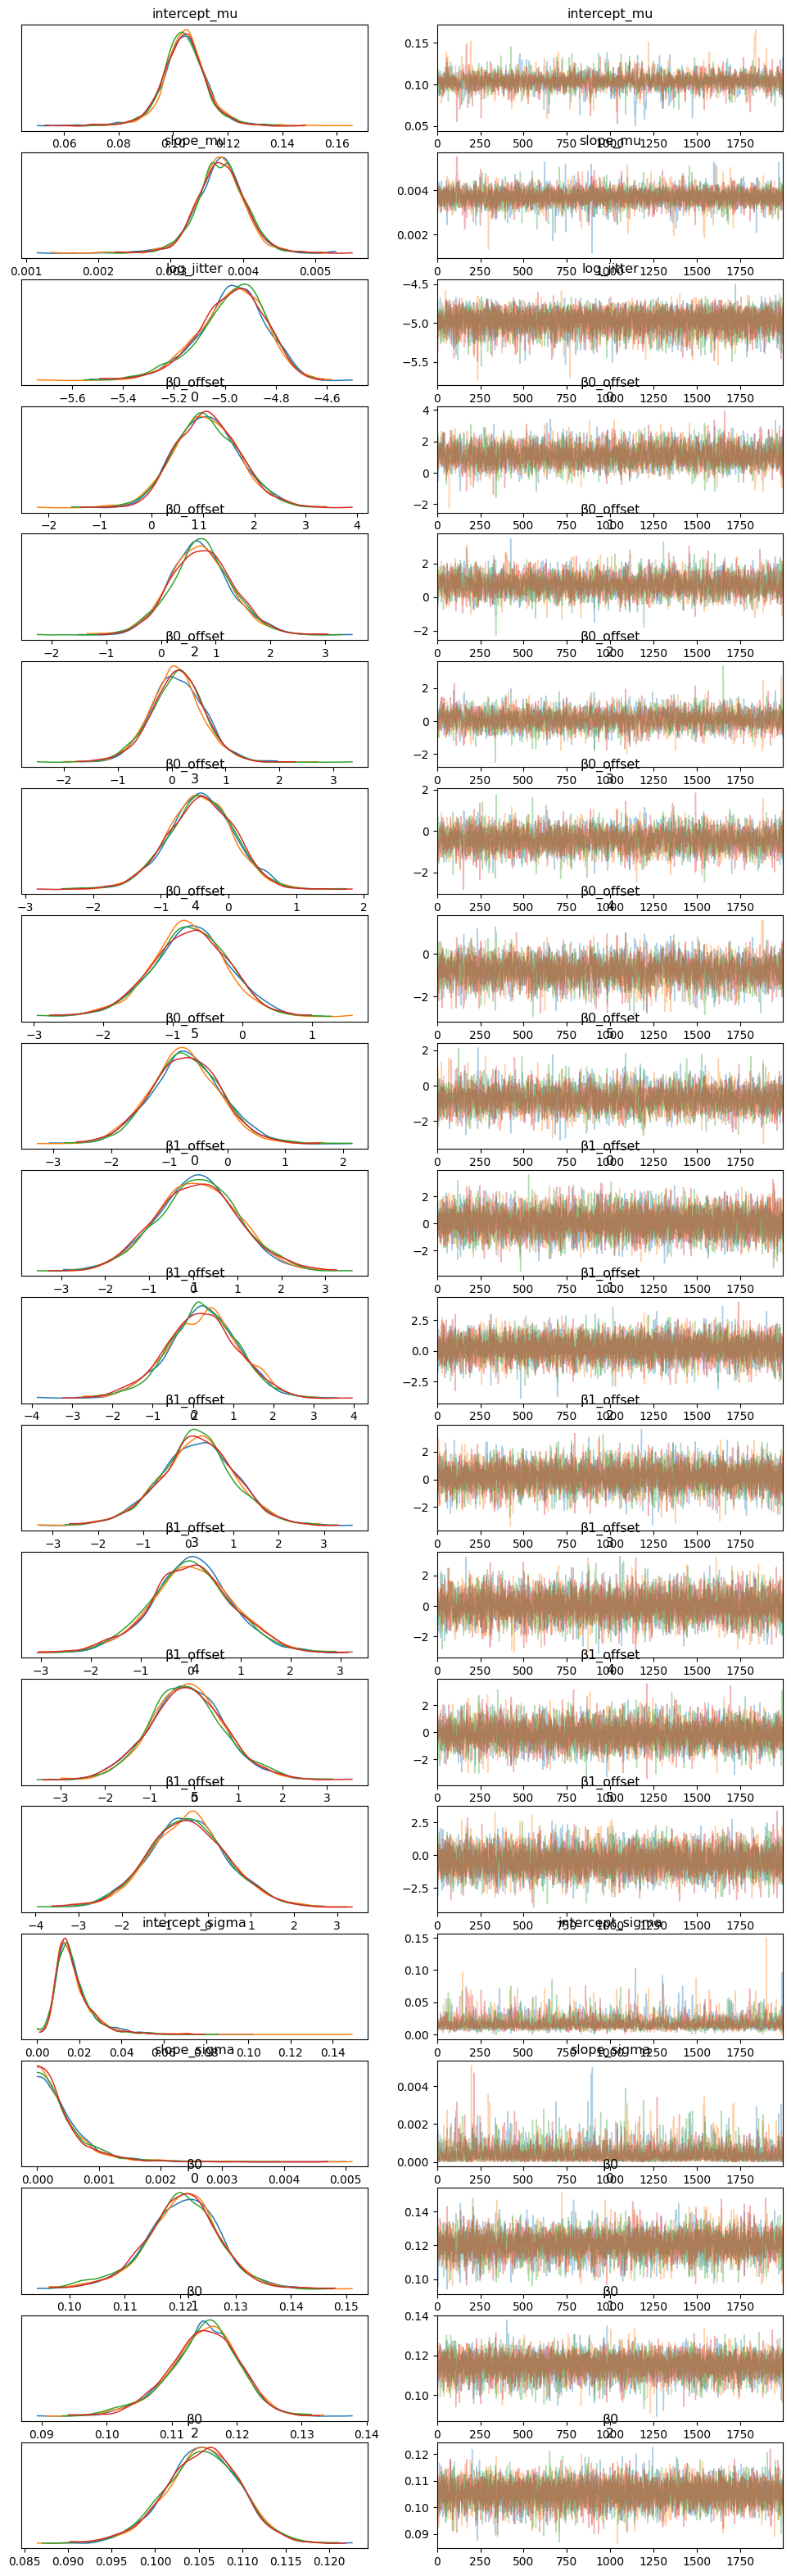

<xarray.Dataset>
Dimensions:          (group: 6, μ_dim_0: 670)
Coordinates:
  * group            (group) int64 0 1 2 3 4 5
  * μ_dim_0          (μ_dim_0) int64 0 1 2 3 4 5 6 ... 664 665 666 667 668 669
Data variables:
    intercept_mu     float64 1.002
    slope_mu         float64 1.0
    log_jitter       float64 1.0
    β0_offset        (group) float64 1.0 1.0 1.001 1.0 1.001 1.002
    β1_offset        (group) float64 1.001 1.001 1.0 1.0 0.9999 1.0
    intercept_sigma  float64 1.001
    slope_sigma      float64 1.003
    β0               (group) float64 1.001 1.0 1.0 1.001 1.001 1.0
    β1               (group) float64 1.0 1.0 1.0 1.002 1.001 1.0
    μ                (μ_dim_0) float64 1.001 1.0 1.001 1.001 ... 1.001 1.0 1.001
    nu               float64 1.0

In [6]:
_ = az.plot_trace(trc_hier, compact=False)
plt.show()
az.rhat(trc_hier)

In [7]:
with hierarchical:
    ddd = pm.sample_posterior_predictive(trc_hier, var_names=["μ", "y", "β0", "β1", "intercept_mu", "slope_mu"])

## Creatng Figure 7

In [8]:
def colorbar_index(ncolors, cmap, ax, fig, pad=0.1, cax=None, orientation='horizontal'):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    if cax is not None:
        colorbar = fig.colorbar(mappable, ax=ax, cax=cax, orientation=orientation, aspect=100, pad=pad)
    else:
        colorbar = fig.colorbar(mappable, ax=ax, orientation=orientation, aspect=100, pad=pad)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    return colorbar

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in range(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

<ipython-input-9-74a7feb8794c>:59: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  one_sig, two_sig = az.hdi(group_y, hdi_prob = 0.67), az.hdi(group_y, hdi_prob = 0.95)
<ipython-input-9-74a7feb8794c>:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


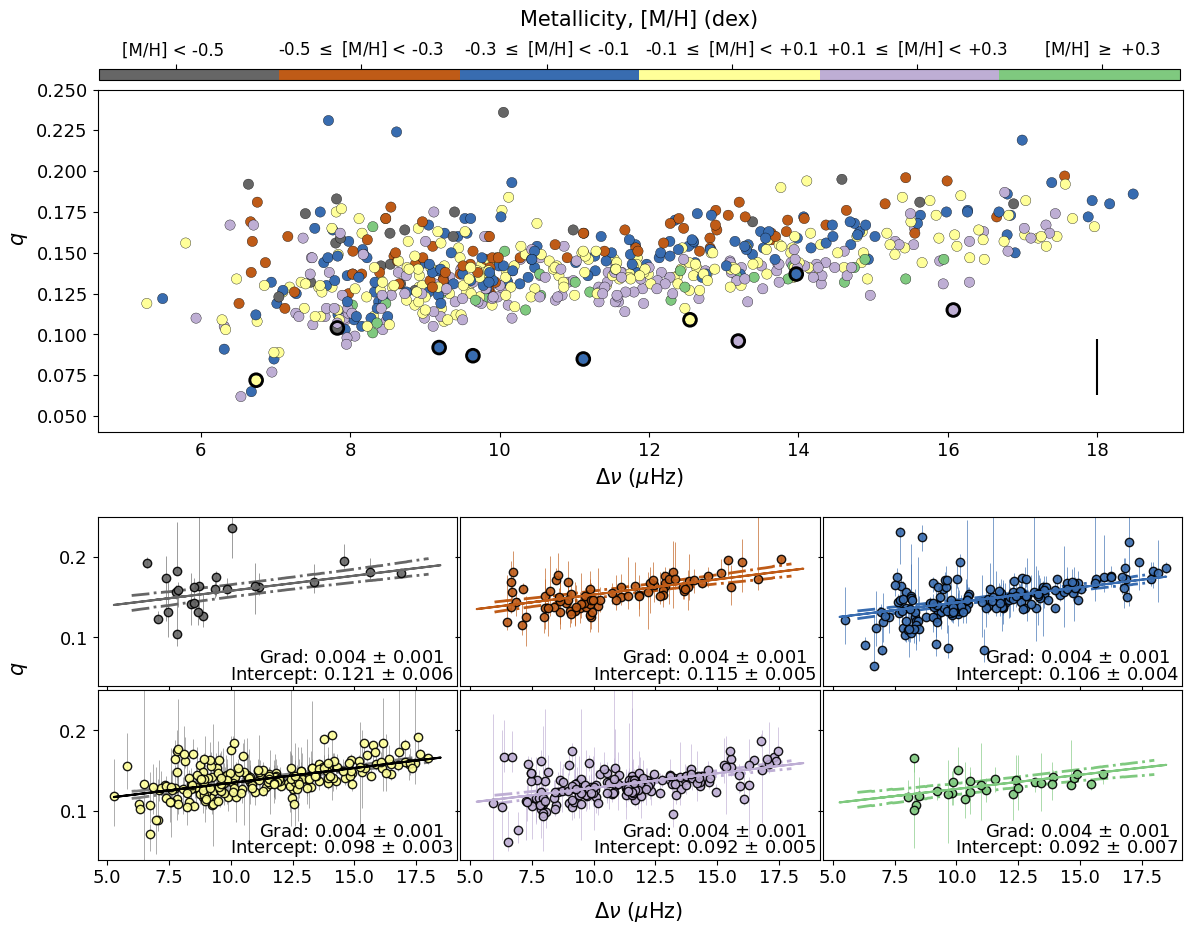

In [9]:
### Version without the final sparse low metallicity bin

from matplotlib import gridspec
import arviz as az

below_degen = np.array([ 4350501,  5639438,  6273090,  6690139,  6690139,  9474201,
        9642805,  9784586, 10645209, 10796857,  8055108]) # stars below the degenerate sequence

feh_labelz = ['[M/H] < -0.5 ', 
                    '-0.5 $\\leq$ [M/H] < -0.3', '-0.3 $\\leq$ [M/H] < -0.1', 
                    '-0.1 $\\leq$ [M/H] < +0.1', '+0.1 $\\leq$ [M/H] < +0.3', '[M/H] $\\geq$ +0.3']

cmap = plt.get_cmap('Accent_r')
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 1, wspace=0.025, hspace=0.245)

fs = 15

gs_ = gridspec.GridSpecFromSubplotSpec(2, 3, wspace=0.01, hspace=0.025, subplot_spec=gs[1])

ax0 = fig.add_subplot(gs[0])
ax1, ax2, ax3 = fig.add_subplot(gs_[0, 0]), fig.add_subplot(gs_[0, 1]), fig.add_subplot(gs_[0, 2])
ax4, ax5, ax6 = fig.add_subplot(gs_[1, 0]), fig.add_subplot(gs_[1, 1]), fig.add_subplot(gs_[1, 2])

axlist = [ax1,ax2,ax3,ax4,ax5,ax6]

im0 = ax0.scatter(corr_df.dnu, corr_df.q, c=corr_df.feh_group, cmap=cmap, edgecolor='k', s=55, lw=0.25)
ax0.scatter(corr_df.dnu[np.in1d(corr_df.KIC.values, below_degen)],
            corr_df.q[np.in1d(corr_df.KIC.values, below_degen)],
            c='none', edgecolor='k', s=85, lw=2)
ax0.errorbar([18], [0.08], yerr=np.median(corr_df['q_E']), fmt='k-')
ax0.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
ax0.set_ylim(0.04, 0.25)
ax0.tick_params(axis='both', which='major', labelsize=fs - 2)

cax = fig.add_axes([0.126, 0.89, 0.772, 0.0105])

cb0 = colorbar_index(ncolors=len(np.unique(corr_df.feh_group)), cmap=cmap, ax=ax0, fig=fig, pad=0.15, cax=cax)

cb0.set_ticklabels(feh_labelz) 
cb0.set_label('Metallicity, [M/H] (dex)', fontsize=fs, labelpad=10)
cb0.ax.tick_params(labelsize=fs-3) 
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')

for i in range(ddd['β0'].shape[1]):    
    if (i >= 2) and (i < 4):
        cz = cmap(i+1)
    elif i == 4:
        cz = cmap(0.8)
    elif i == 5:
        cz = cmap(0.9)
    else:
        cz = cmap(i)
        
        
    dnu_grid = np.linspace(6, 18, 200)
    group_y = np.tile(dnu_grid, (ddd['β1'].shape[0], 1))*np.expand_dims(ddd['β1'][:, i],-1) + np.expand_dims(ddd['β0'][:, i], -1)
    one_sig, two_sig = az.hdi(group_y, hdi_prob = 0.67), az.hdi(group_y, hdi_prob = 0.95)
    
    
    if i != 3:
        axlist[i].plot(corr_df.dnu, corr_df.dnu*np.median(ddd['β1'][:, i]) + np.median(ddd['β0'][:, i]),
                c=cz, zorder=3)
        axlist[i].plot(dnu_grid, two_sig[:,0], 
                         c=cz, lw=2, ls='-.'); axlist[i].plot(dnu_grid, two_sig[:,1], c=cz, lw=2, ls='-.')
        axlist[i].errorbar(corr_df.dnu[corr_df.feh_group == i], 
                    corr_df.q[corr_df.feh_group == i],
                    yerr=[corr_df.q_e[corr_df.feh_group == i],
                         corr_df.q_E[corr_df.feh_group == i]], fmt='o', alpha=0.9,
                            c=cz,  markeredgecolor='k', lw=0.5)
    else:
        axlist[i].plot(corr_df.dnu, corr_df.dnu*np.median(ddd['β1'][:, i]) + np.median(ddd['β0'][:, i]),
                c='k', zorder=3)
        axlist[i].plot(dnu_grid, two_sig[:,0], 
                         c='gray', lw=2, ls='-.'); axlist[i].plot(dnu_grid, two_sig[:,1], c='gray', lw=2, ls='-.')
         
        axlist[i].errorbar(corr_df.dnu[corr_df.feh_group == i], 
                corr_df.q[corr_df.feh_group == i],
                yerr=[corr_df.q_e[corr_df.feh_group == i],
                     corr_df.q_E[corr_df.feh_group == i]], fmt='o', alpha=0.9,
                        c=cz,  markeredgecolor='k', lw=0.5, ecolor='gray')       
    
    pm_one_sig_grad = np.median(ddd['β1'][:, i]) - az.hdi(ddd['β1'][:, i], hdi_prob=0.67)[0]
    if np.round(pm_one_sig_grad,3) == 0:
        pm_one_sig_grad += 0.001
    pm_one_sig_intercept = np.median(ddd['β0'][:, i]) - az.hdi(ddd['β0'][:, i], hdi_prob=0.67)[0]
    axlist[i].text(x=0.45, y=0.135, transform = axlist[i].transAxes,
                     s='Grad: %.3f $\\pm$ %.3f' %(np.median(ddd['β1'][:, i]), 
                                                  pm_one_sig_grad)
                    , fontsize=fs-2)
    axlist[i].text(x=0.368, y=0.038, transform = axlist[i].transAxes,
                     s='Intercept: %.3f $\\pm$ %.3f' %(np.median(ddd['β0'][:, i]), pm_one_sig_intercept)
                    , fontsize=fs-2)
    
    axlist[i].set_ylim(0.04, 0.25)
    if i not in [0,3]:
        axlist[i].set_yticklabels([])
        
    if i in [0,1,2]:
        axlist[i].set_xticklabels([])
    axlist[i].tick_params(axis='both', which='major', labelsize=fs-2)

fig.text(x=0.0625, y=0.73, s='$q$', rotation=90, fontsize=fs)
fig.text(x=0.0625, y=0.3, s='$q$', rotation=90, fontsize=fs)
fig.text(x=0.48, y=0.0515, s='$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
plt.tight_layout()
plt.show()

## Plot for Figure 9, enhanced

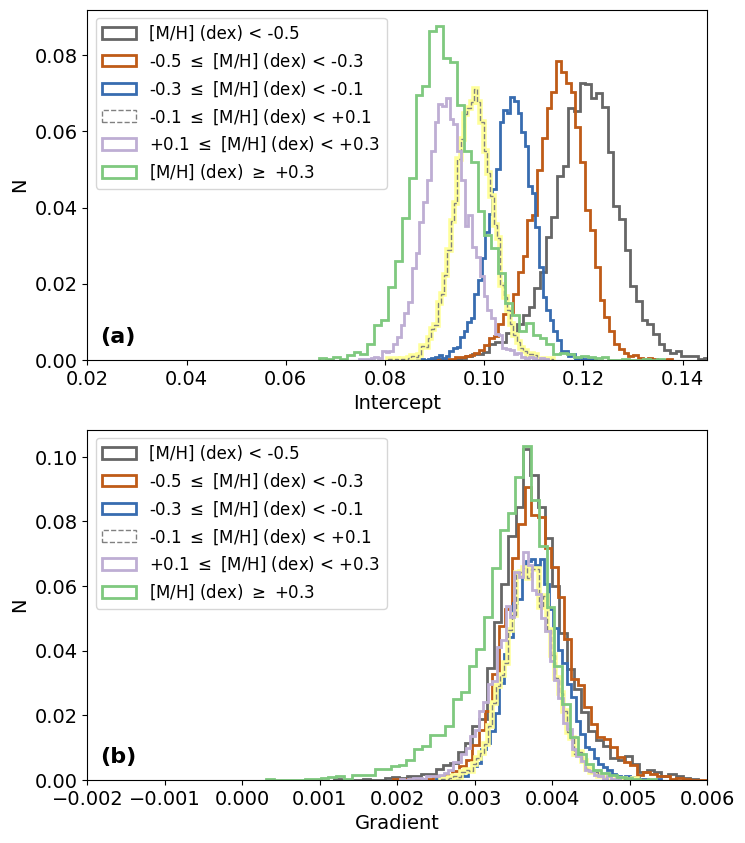

In [28]:
feh_labelz = ['[M/H] (dex) < -0.5 ', 
                    '-0.5 $\\leq$ [M/H] (dex) < -0.3', '-0.3 $\\leq$ [M/H] (dex) < -0.1', 
                    '-0.1 $\\leq$ [M/H] (dex) < +0.1', '+0.1 $\\leq$ [M/H] (dex) < +0.3', '[M/H] (dex) $\\geq$ +0.3']

fig = plt.figure(figsize=(8,10))
ax1, ax2 = fig.add_subplot(211), fig.add_subplot(212)
for i in range(ddd['β0'].shape[1]):
    if (i >= 2) and (i < 4):
        cz = cmap(i+1)
    elif i == 4:
        cz = cmap(0.8)
    elif i == 5:
        cz = cmap(0.9)
    else:
        cz = cmap(i)
    if i != 3:
        ax1.hist(ddd['β0'][:, i], histtype='step', bins=50, label=feh_labelz[i], color=cz, lw=2,
                weights = np.ones_like(ddd['β0'][:, i])/len(ddd['β0'][:, i]))
        ax2.hist(ddd['β1'][:, i], histtype='step', bins=50, label=feh_labelz[i], color=cz, lw=2,
                weights = np.ones_like(ddd['β1'][:, i])/len(ddd['β1'][:, i]))
    else:
        ax1.hist(ddd['β0'][:, i], histtype='step', bins=50, color=cz, lw=4,
                weights = np.ones_like(ddd['β0'][:, i])/len(ddd['β0'][:, i]))
        ax1.hist(ddd['β0'][:, i], histtype='step', bins=50, lw=1, 
                 weights = np.ones_like(ddd['β0'][:, i])/len(ddd['β0'][:, i]), color='gray', ls='--'
                , label=feh_labelz[i])
        ax2.hist(ddd['β1'][:, i], histtype='step', bins=50, color=cz, lw=4,
                weights = np.ones_like(ddd['β1'][:, i])/len(ddd['β1'][:, i]))
        ax2.hist(ddd['β1'][:, i], histtype='step', bins=50, lw=1, 
                 weights = np.ones_like(ddd['β1'][:, i])/len(ddd['β1'][:, i]), color='gray', ls='--'
                , label=feh_labelz[i])
     
ax1.set_xlim(0.02, 0.145)
ax1.set_ylabel('N', fontsize=14)
ax1.set_xlabel('Intercept', fontsize=14)
ax1.legend(prop={'size': 12})
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.text(x=0.02, y=0.05, transform=ax1.transAxes, fontsize=16, s='(a)', fontweight='bold')
ax2.text(x=0.02, y=0.05, transform=ax2.transAxes, fontsize=16, s='(b)', fontweight='bold')


ax2.set_xlim(-0.002, 0.006)
ax2.set_ylabel('N', fontsize=14)
ax2.set_xlabel('Gradient', fontsize=14)
ax2.legend(prop={'size': 12}, loc='upper left')
ax2.tick_params(axis='both', which='major', labelsize=14)

plt.show()

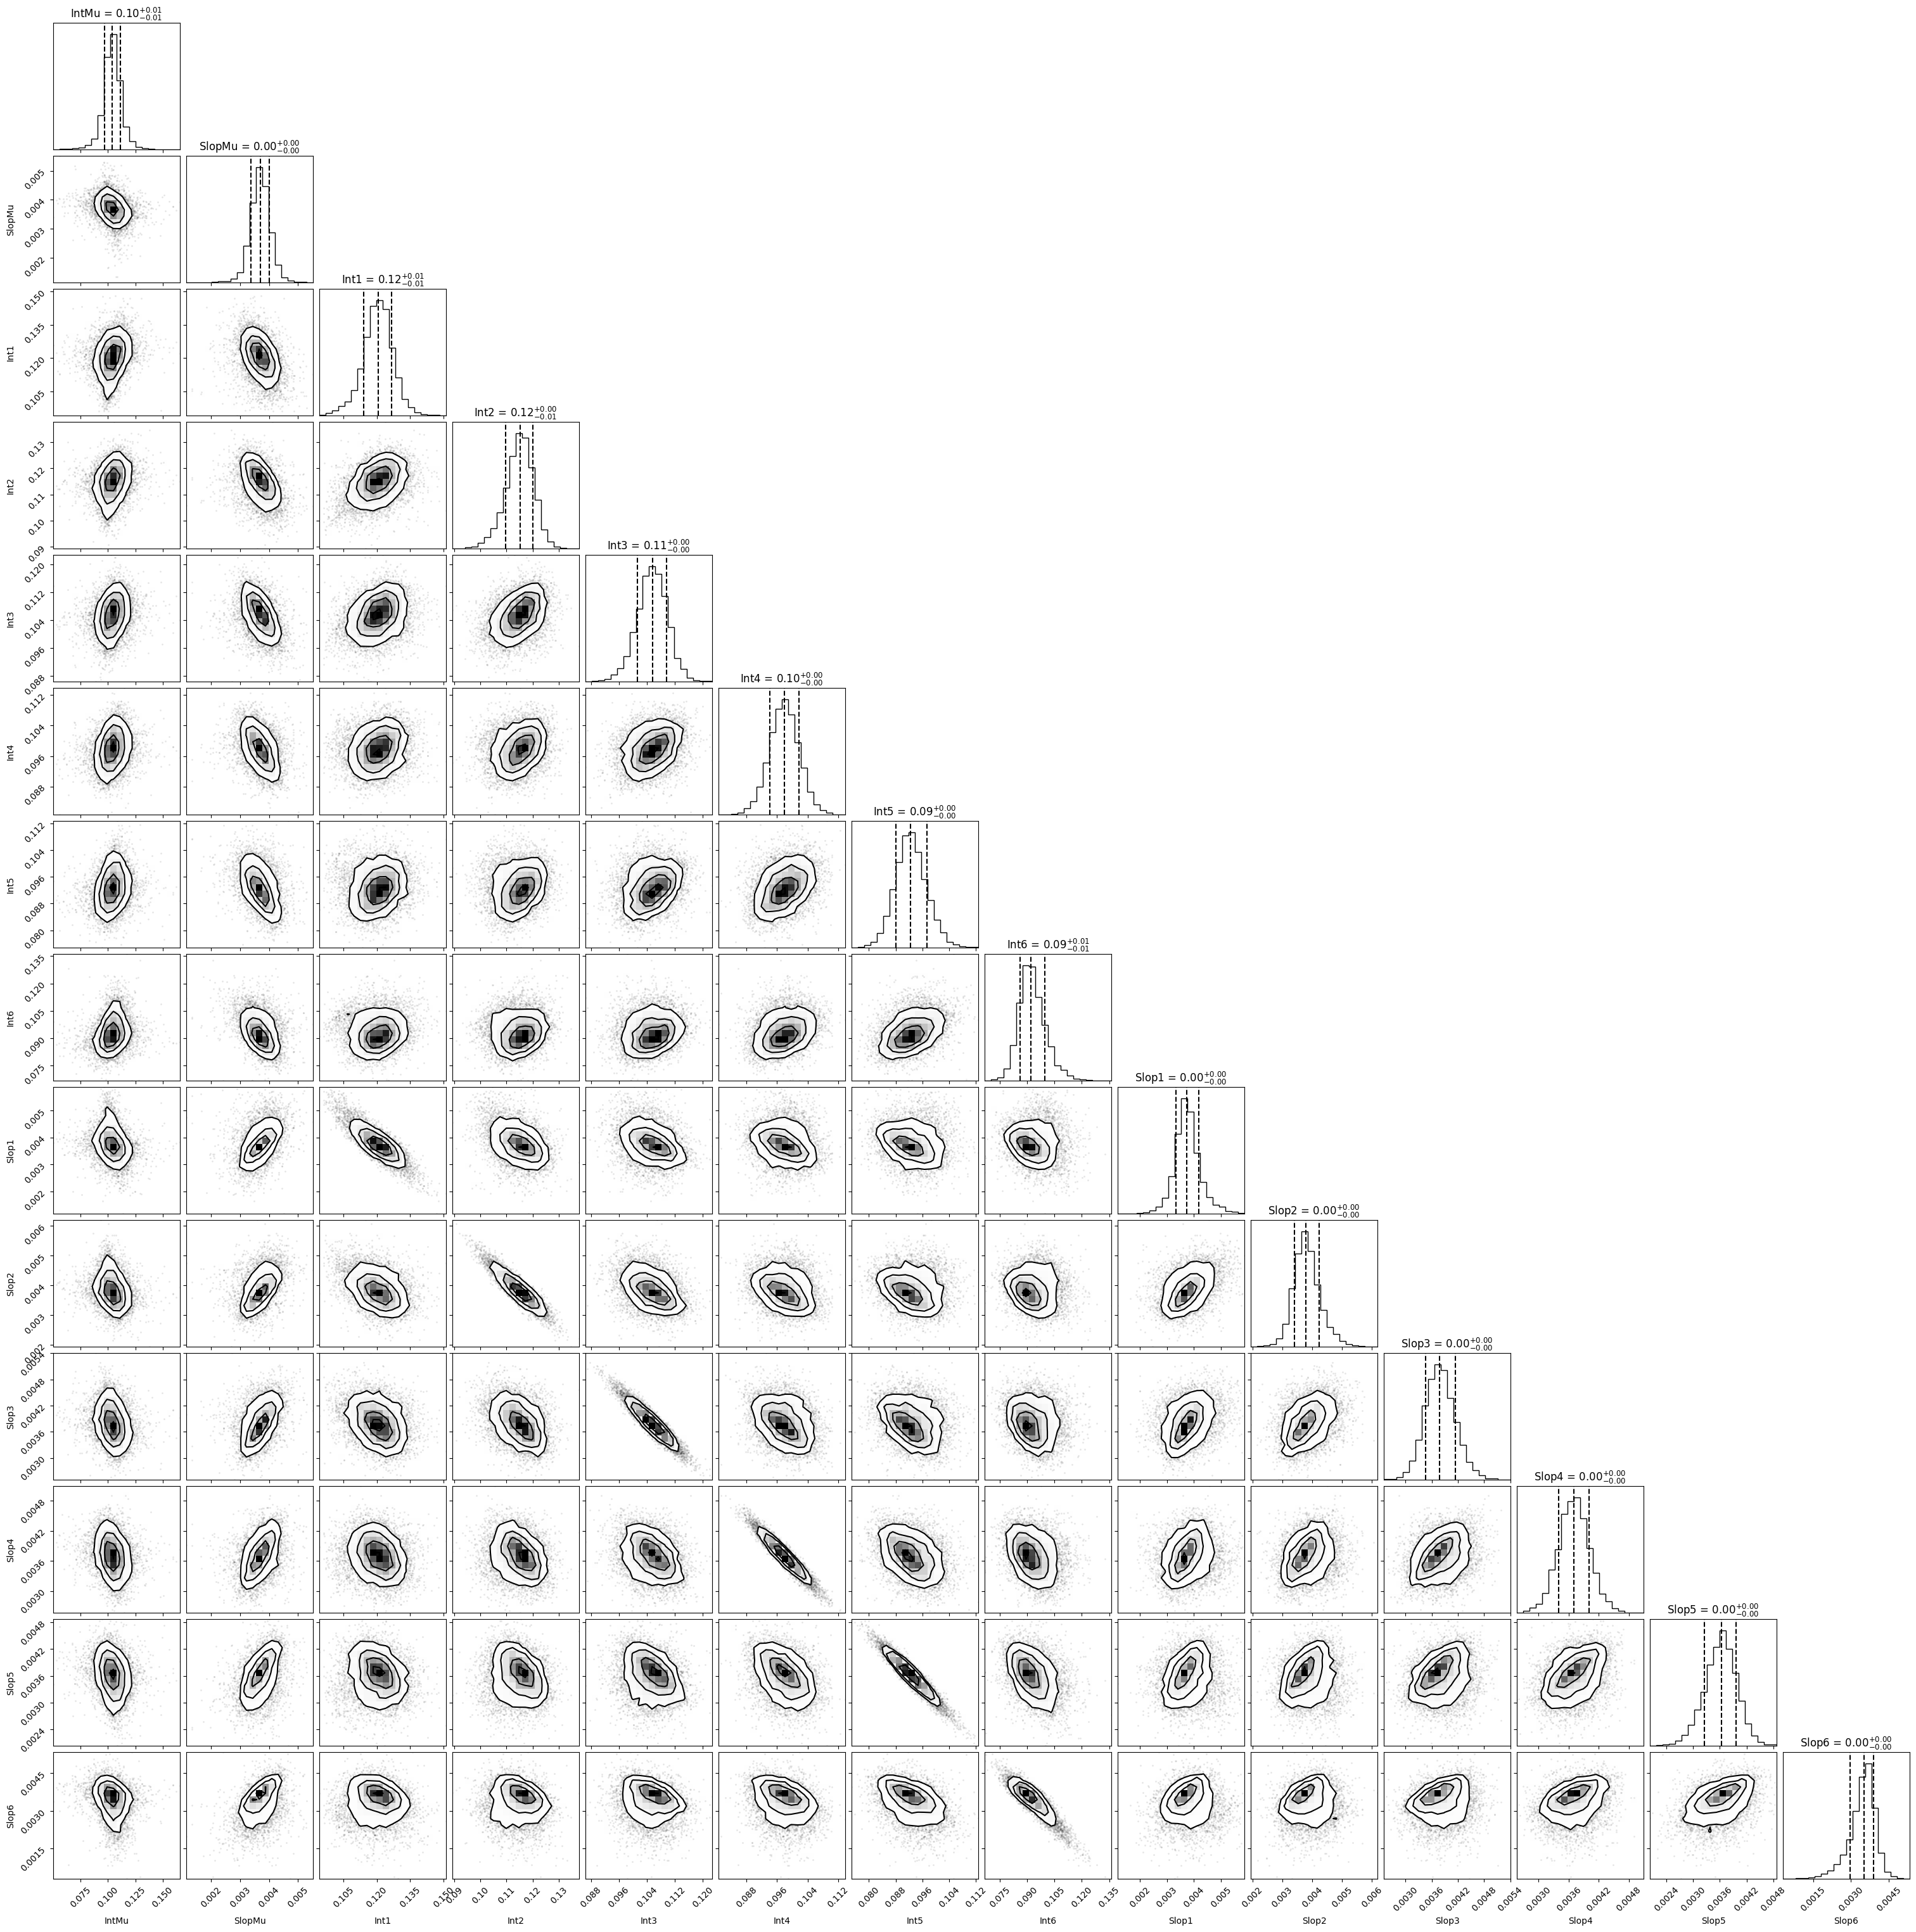

In [29]:
corner_data = np.concatenate([ddd['intercept_mu'].reshape(-1,1), ddd['slope_mu'].reshape(-1,1), 
                ddd['β0'], ddd['β1']], axis=1)

labels=['IntMu', 'SlopMu', 'Int1', 'Int2', 'Int3', 'Int4', "Int5", 'Int6',
        'Slop1', 'Slop2', 'Slop3', 'Slop4', 'Slop5', 'Slop6']

figure = corner.corner(
    corner_data,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)
plt.show()

## Hierarchical model for mass binning

In [30]:
group_list_mass = np.unique(corr_df['mass_group'])


non_centered = True

coords_mass = {"group": np.unique(corr_df.mass_group),
    "obs_id": np.arange(len(corr_df.mass_group))}

with pm.Model(coords=coords_mass) as hierarchical_mass:
    
    mass_idx = pm.Data("mass_idx", corr_df.mass_group.values, dims="obs_id")
    
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=100)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=5)
    slope_mu = pm.Normal("slope_mu", 0, sigma=100)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=5)
    
    yerr = corr_df['max_q_err'].values
    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

    β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
    β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")
    β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
    β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")


    x = pm.Data("x", corr_df['dnu'].values, dims="obs_id")
    μ = pm.Deterministic("μ", β0[mass_idx] + β1[mass_idx] * x)

    nu = pm.InverseGamma("nu", alpha=1, beta=1)
    pm.StudentT("y", mu=μ, nu=nu, sigma= np.sqrt(yerr**2 + np.exp(2 * log_jitter)),
                observed=corr_df['q'], dims="obs_id")


In [31]:
with hierarchical_mass:
    trc_hier_mass = pm.sample(
        tune=15000,
        draws=2000,
        target_accept=0.99,
        chains=4,
        cores=4,
        init="advi+adapt_diag",
        n_init=50000,
        progressbar=True,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = -1,540.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, β1_offset, β0_offset, log_jitter, slope_sigma, slope_mu, intercept_sigma, intercept_mu]


Sampling 4 chains for 15_000 tune and 2_000 draw iterations (60_000 + 8_000 draws total) took 631 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/home/marc/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (700), generating only 20 plots
  warnings.warn(


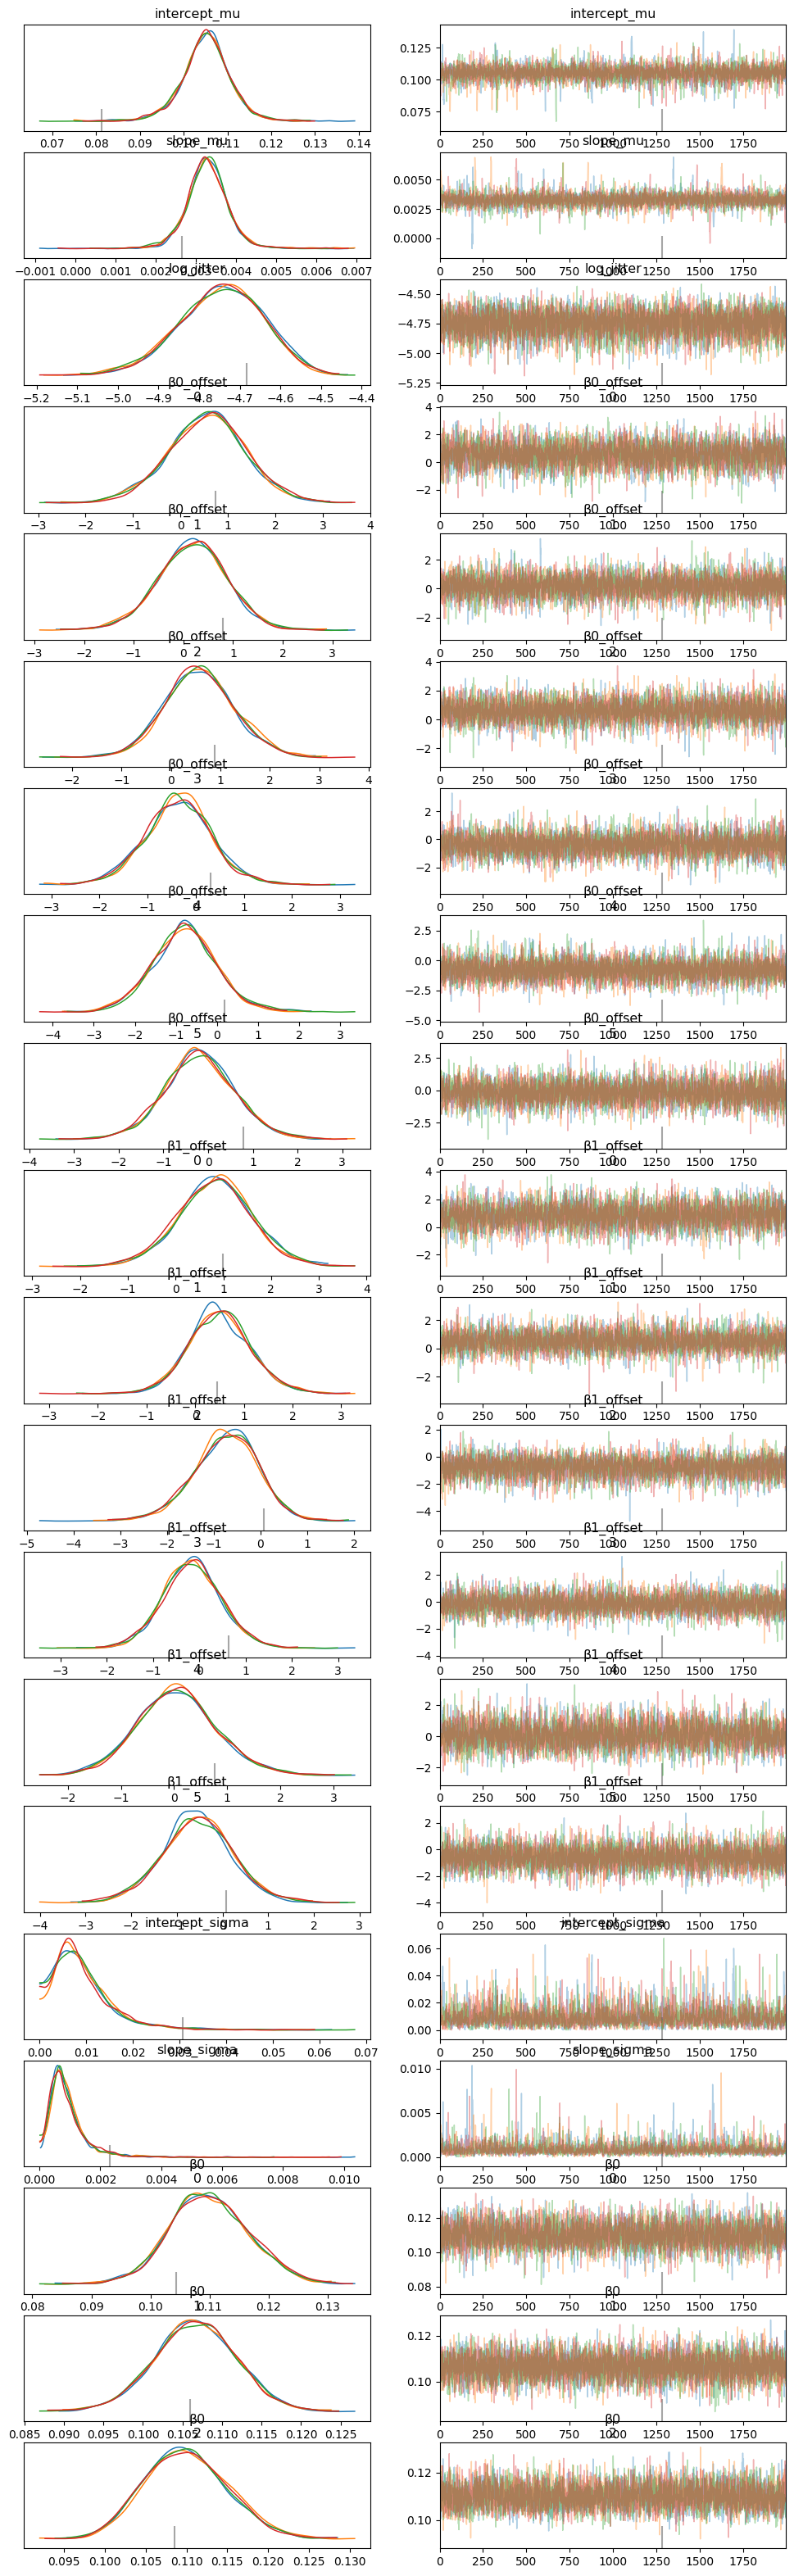

<xarray.Dataset>
Dimensions:          (group: 6, μ_dim_0: 670)
Coordinates:
  * group            (group) int64 0 1 2 3 4 5
  * μ_dim_0          (μ_dim_0) int64 0 1 2 3 4 5 6 ... 664 665 666 667 668 669
Data variables:
    intercept_mu     float64 1.002
    slope_mu         float64 1.001
    log_jitter       float64 1.0
    β0_offset        (group) float64 1.001 1.0 1.001 1.001 1.001 1.0
    β1_offset        (group) float64 1.001 0.9998 1.001 1.001 1.001 1.0
    intercept_sigma  float64 1.001
    slope_sigma      float64 1.001
    β0               (group) float64 1.0 0.9999 1.0 1.001 1.0 1.0
    β1               (group) float64 1.0 0.9998 1.0 1.001 1.0 1.0
    μ                (μ_dim_0) float64 1.001 1.0 0.9999 1.0 ... 1.0 0.9999 1.001
    nu               float64 1.001

In [32]:
_ = az.plot_trace(trc_hier_mass, compact=False) 
plt.show()
az.rhat(trc_hier_mass)

In [33]:
with hierarchical_mass:
    ddd_mass = pm.sample_posterior_predictive(trc_hier_mass, var_names=["μ", "y", "β0", "β1", "intercept_mu", "slope_mu"])

## Creating Figure 8

<ipython-input-34-854a81fbab25>:51: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  one_sig, two_sig = az.hdi(group_y, hdi_prob = 0.67), az.hdi(group_y, hdi_prob = 0.95)
<ipython-input-34-854a81fbab25>:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


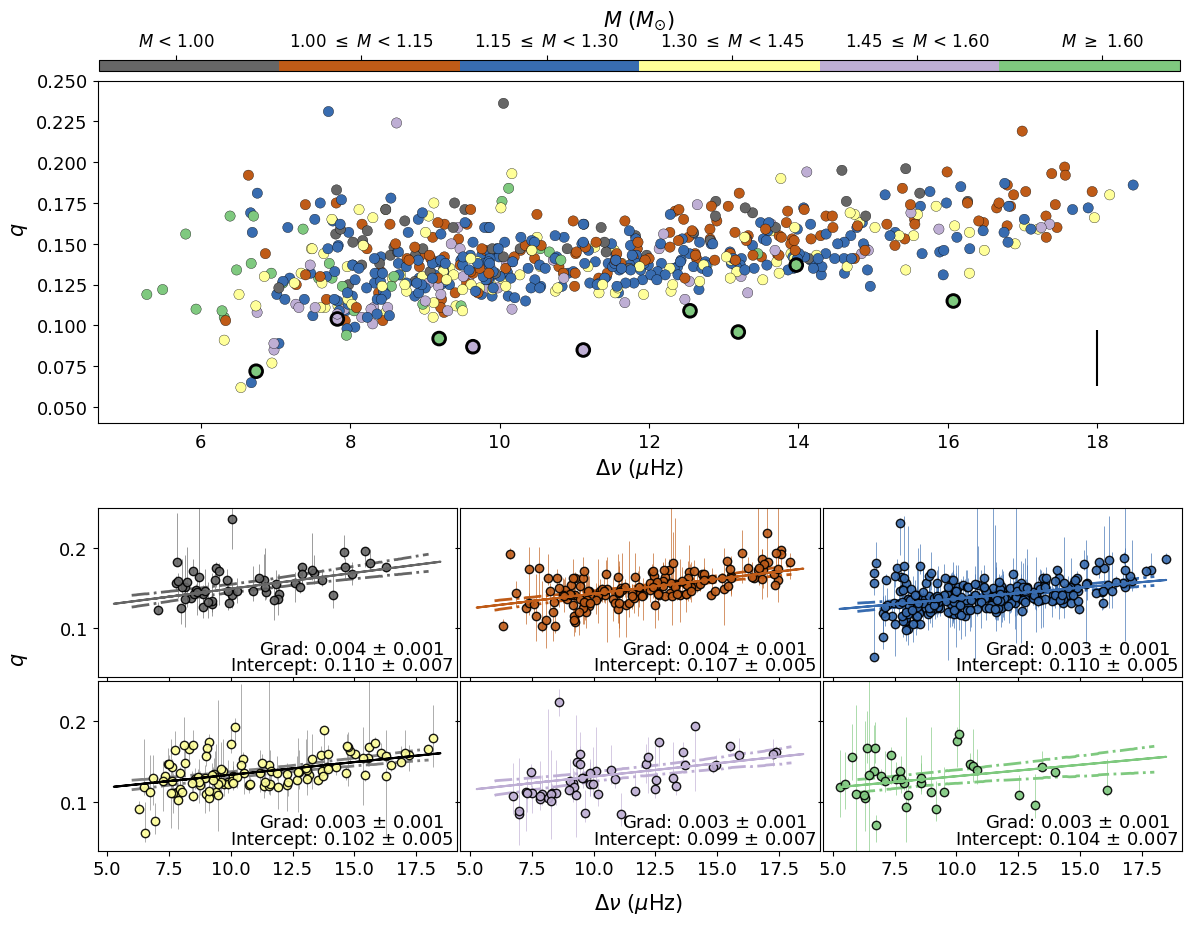

In [34]:
from matplotlib import gridspec
import arviz as az

cmap = plt.get_cmap('Accent_r')
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 1, wspace=0.025, hspace=0.245)

fs = 15

gs_ = gridspec.GridSpecFromSubplotSpec(2, 3, wspace=0.01, hspace=0.025, subplot_spec=gs[1])

ax0 = fig.add_subplot(gs[0])
ax1, ax2, ax3 = fig.add_subplot(gs_[0, 0]), fig.add_subplot(gs_[0, 1]), fig.add_subplot(gs_[0, 2])
ax4, ax5, ax6 = fig.add_subplot(gs_[1, 0]), fig.add_subplot(gs_[1, 1]), fig.add_subplot(gs_[1, 2])

axlist = [ax1,ax2,ax3,ax4,ax5,ax6]

im0 = ax0.scatter(corr_df.dnu, corr_df.q, c=corr_df.mass_group, cmap=cmap, edgecolor='k', s=55, lw=0.25)
ax0.scatter(corr_df.dnu[np.in1d(corr_df.KIC.values, below_degen)],
            corr_df.q[np.in1d(corr_df.KIC.values, below_degen)],
            c='none', edgecolor='k', s=85, lw=2)
ax0.errorbar([18], [0.08], yerr=np.median(corr_df['q_E']), fmt='k-')
ax0.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
ax0.set_ylim(0.04, 0.25)
ax0.tick_params(axis='both', which='major', labelsize=fs-2)

cax = fig.add_axes([0.126, 0.89, 0.772, 0.0105])
cb0 = colorbar_index(ncolors=len(np.unique(corr_df.mass_group)), cmap=cmap, ax=ax0, fig=fig, pad=0.15, cax=cax)    
cb0.set_ticklabels(['$M$ < 1.00', '1.00 $\\leq$ $M$ < 1.15',
                    '1.15 $\\leq$ $M$ < 1.30', '1.30 $\\leq$ $M$ < 1.45', 
                    '1.45 $\\leq$ $M$ < 1.60', '$M$ $\\geq$ 1.60']) 
cb0.set_label('$M$ ($M_{\\odot}$)', fontsize=fs)
cb0.ax.tick_params(labelsize=fs-3) 
cax.xaxis.set_label_position('top')
cax.xaxis.set_ticks_position('top')



for i in range(ddd_mass['β0'].shape[1]):
    
    if i >= 4:
        cz = cmap(i+2)
    elif i >= 2:
        cz = cmap(i+1)
    else:
        cz = cmap(i)
        
            
    dnu_grid = np.linspace(6, 18, 200)
    group_y = np.tile(dnu_grid, (ddd_mass['β1'].shape[0], 1))*np.expand_dims(ddd_mass['β1'][:, i],-1) + np.expand_dims(ddd_mass['β0'][:, i], -1)
    one_sig, two_sig = az.hdi(group_y, hdi_prob = 0.67), az.hdi(group_y, hdi_prob = 0.95)
    
    
    if i != 3:
        axlist[i].plot(corr_df.dnu, corr_df.dnu*np.median(ddd_mass['β1'][:, i]) + np.median(ddd_mass['β0'][:, i]),
                c=cz, zorder=3)
        axlist[i].plot(dnu_grid, two_sig[:,0], 
                         c=cz, lw=2, ls='-.'); axlist[i].plot(dnu_grid, two_sig[:,1], c=cz, lw=2, ls='-.')
        axlist[i].errorbar(corr_df.dnu[corr_df.mass_group == i], 
                    corr_df.q[corr_df.mass_group == i],
                    yerr=[corr_df.q_e[corr_df.mass_group == i],
                         corr_df.q_E[corr_df.mass_group == i]], fmt='o', alpha=0.9,
                            c=cz,  markeredgecolor='k', lw=0.5)
    else:
        axlist[i].plot(corr_df.dnu, corr_df.dnu*np.median(ddd_mass['β1'][:, i]) + np.median(ddd_mass['β0'][:, i]),
                c='k', zorder=3)
        axlist[i].plot(dnu_grid, two_sig[:,0], 
                         c='gray', lw=2, ls='-.'); axlist[i].plot(dnu_grid, two_sig[:,1], c='gray', lw=2, ls='-.')
         
        axlist[i].errorbar(corr_df.dnu[corr_df.mass_group == i], 
                corr_df.q[corr_df.mass_group == i],
                yerr=[corr_df.q_e[corr_df.mass_group == i],
                     corr_df.q_E[corr_df.mass_group == i]], fmt='o', alpha=0.9,
                        c=cz,  markeredgecolor='k', lw=0.5, ecolor='gray')       
    
    pm_one_sig_grad = np.median(ddd_mass['β1'][:, i]) - az.hdi(ddd_mass['β1'][:, i], hdi_prob=0.67)[0]
    if np.round(pm_one_sig_grad,3) == 0:
        pm_one_sig_grad += 0.001
    axlist[i].text(x=0.45, y=0.135, transform = axlist[i].transAxes,
                     s='Grad: %.3f $\\pm$ %.3f' %(np.median(ddd_mass['β1'][:, i]), 
                                                  pm_one_sig_grad)
                    , fontsize=fs-2)
    
    axlist[i].text(x=0.368, y=0.038, transform = axlist[i].transAxes,
                     s='Intercept: %.3f $\\pm$ %.3f' %(np.median(ddd_mass['β0'][:, i]), 
                                                  np.median(ddd_mass['β0'][:, i]) - az.hdi(ddd_mass['β0'][:, i],
                                                                                      hdi_prob=0.67)[0])
                    , fontsize=fs-2)
    
    axlist[i].set_ylim(0.04, 0.25)
    if i not in [0,3]:
        axlist[i].set_yticklabels([])
        
    if i in [0,1,2]:
        axlist[i].set_xticklabels([])
    axlist[i].tick_params(axis='both', which='major', labelsize=fs-2)

fig.text(x=0.0625, y=0.73, s='$q$', rotation=90, fontsize=fs)
fig.text(x=0.0625, y=0.3, s='$q$', rotation=90, fontsize=fs)
fig.text(x=0.48, y=0.0515, s='$\\Delta\\nu$ ($\\mu$Hz)', fontsize=fs)
plt.tight_layout()

plt.show()

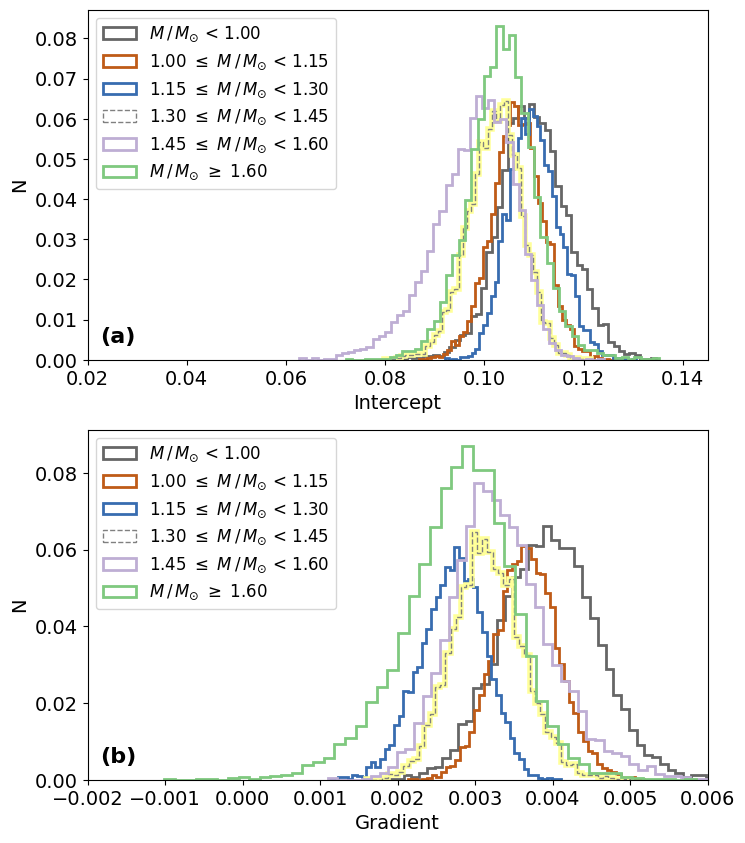

In [40]:
mass_labelz = ['$M\\,/\\,M_{\\odot}$ < 1.00', '1.00 $\\leq$ $M\\,/\\,M_{\\odot}$ < 1.15',
                    '1.15 $\\leq$ $M\\,/\\,M_{\\odot}$ < 1.30', '1.30 $\\leq$ $M\\,/\\,M_{\\odot}$ < 1.45', 
                    '1.45 $\\leq$ $M\\,/\\,M_{\\odot}$ < 1.60', '$M\\,/\\,M_{\\odot}$ $\\geq$ 1.60']
fig = plt.figure(figsize=(8,10))
ax1, ax2 = fig.add_subplot(211), fig.add_subplot(212)
for i in range(ddd_mass['β0'].shape[1]):
    if (i >= 2) and (i < 4):
        cz = cmap(i+1)
    elif i == 4:
        cz = cmap(0.8)
    elif i == 5:
        cz = cmap(0.9)
    else:
        cz = cmap(i)
    if i != 3:
        ax1.hist(ddd_mass['β0'][:, i], histtype='step', bins=50, label=mass_labelz[i], color=cz, lw=2,
                weights = np.ones_like(ddd_mass['β0'][:, i])/len(ddd_mass['β0'][:, i]))
        ax2.hist(ddd_mass['β1'][:, i], histtype='step', bins=50, label=mass_labelz[i], color=cz, lw=2,
                weights = np.ones_like(ddd_mass['β1'][:, i])/len(ddd_mass['β1'][:, i]))
    else:
        ax1.hist(ddd_mass['β0'][:, i], histtype='step', bins=50, color=cz, lw=4,
                weights = np.ones_like(ddd_mass['β0'][:, i])/len(ddd_mass['β0'][:, i]))
        ax1.hist(ddd_mass['β0'][:, i], histtype='step', bins=50, lw=1, 
                 weights = np.ones_like(ddd_mass['β0'][:, i])/len(ddd_mass['β0'][:, i]), color='gray', ls='--'
                , label=mass_labelz[i])
        ax2.hist(ddd_mass['β1'][:, i], histtype='step', bins=50, color=cz, lw=4,
                weights = np.ones_like(ddd_mass['β1'][:, i])/len(ddd_mass['β1'][:, i]))
        ax2.hist(ddd_mass['β1'][:, i], histtype='step', bins=50, lw=1, 
                 weights = np.ones_like(ddd_mass['β1'][:, i])/len(ddd_mass['β1'][:, i]), color='gray', ls='--'
                , label=mass_labelz[i])
     
ax1.set_xlim(0.02, 0.145)
ax1.set_ylabel('N', fontsize=14)
ax1.set_xlabel('Intercept', fontsize=14)
ax1.legend(prop={'size': 12})
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.set_xlim(-0.002, 0.006)
ax2.set_ylabel('N', fontsize=14)
ax2.set_xlabel('Gradient', fontsize=14)
ax2.legend(prop={'size': 12}, loc='upper left')
ax2.tick_params(axis='both', which='major', labelsize=14)

ax1.text(x=0.02, y=0.05, transform=ax1.transAxes, fontsize=16, s='(a)', fontweight='bold')
ax2.text(x=0.02, y=0.05, transform=ax2.transAxes, fontsize=16, s='(b)', fontweight='bold')

plt.show()

## Combining the metallicity and mass histograms

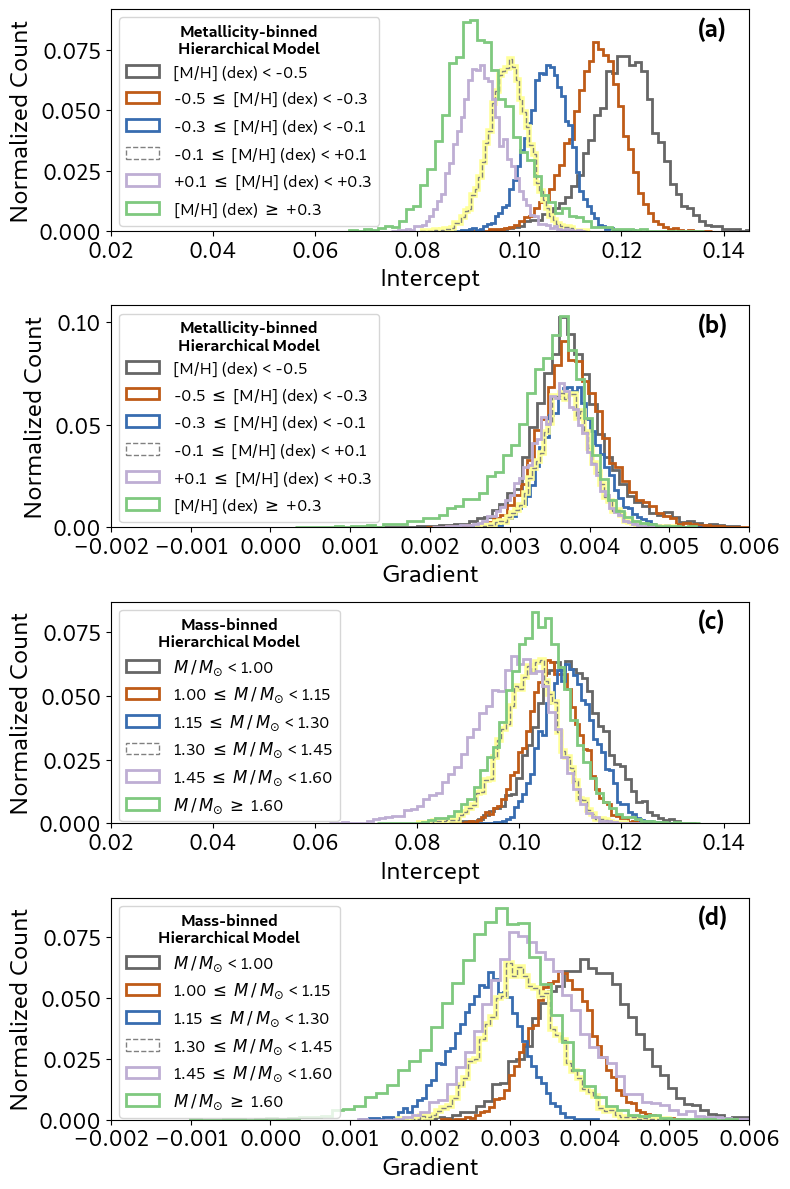

In [76]:
import matplotlib as mpl
mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Cantarell']

feh_labelz = ['[M/H] (dex) < -0.5 ', 
                    '-0.5 $\\leq$ [M/H] (dex) < -0.3', '-0.3 $\\leq$ [M/H] (dex) < -0.1', 
                    '-0.1 $\\leq$ [M/H] (dex) < +0.1', '+0.1 $\\leq$ [M/H] (dex) < +0.3', '[M/H] (dex) $\\geq$ +0.3']

mass_labelz = ['$M\\,/\\,M_{\\odot}$ < 1.00', '1.00 $\\leq$ $M\\,/\\,M_{\\odot}$ < 1.15',
                    '1.15 $\\leq$ $M\\,/\\,M_{\\odot}$ < 1.30', '1.30 $\\leq$ $M\\,/\\,M_{\\odot}$ < 1.45', 
                    '1.45 $\\leq$ $M\\,/\\,M_{\\odot}$ < 1.60', '$M\\,/\\,M_{\\odot}$ $\\geq$ 1.60']

fig = plt.figure(figsize=(8,12))
fs = 18

ax1met, ax2met = fig.add_subplot(411), fig.add_subplot(412)
for i in range(ddd['β0'].shape[1]):
    if (i >= 2) and (i < 4):
        cz = cmap(i+1)
    elif i == 4:
        cz = cmap(0.8)
    elif i == 5:
        cz = cmap(0.9)
    else:
        cz = cmap(i)
    if i != 3:
        ax1met.hist(ddd['β0'][:, i], histtype='step', bins=50, label=feh_labelz[i], color=cz, lw=2,
                weights = np.ones_like(ddd['β0'][:, i])/len(ddd['β0'][:, i]))
        ax2met.hist(ddd['β1'][:, i], histtype='step', bins=50, label=feh_labelz[i], color=cz, lw=2,
                weights = np.ones_like(ddd['β1'][:, i])/len(ddd['β1'][:, i]))
    else:
        ax1met.hist(ddd['β0'][:, i], histtype='step', bins=50, color=cz, lw=4,
                weights = np.ones_like(ddd['β0'][:, i])/len(ddd['β0'][:, i]))
        ax1met.hist(ddd['β0'][:, i], histtype='step', bins=50, lw=1, 
                 weights = np.ones_like(ddd['β0'][:, i])/len(ddd['β0'][:, i]), color='gray', ls='--'
                , label=feh_labelz[i])
        ax2met.hist(ddd['β1'][:, i], histtype='step', bins=50, color=cz, lw=4,
                weights = np.ones_like(ddd['β1'][:, i])/len(ddd['β1'][:, i]))
        ax2met.hist(ddd['β1'][:, i], histtype='step', bins=50, lw=1, 
                 weights = np.ones_like(ddd['β1'][:, i])/len(ddd['β1'][:, i]), color='gray', ls='--'
                , label=feh_labelz[i])
     
ax1met.set_xlim(0.02, 0.145)
ax1met.set_ylabel('Normalized Count', fontsize=fs)
ax1met.set_xlabel('Intercept', fontsize=fs)
l = ax1met.legend(prop={'size': fs-6}, title='Metallicity-binned\nHierarchical Model')
plt.setp(l.get_title(),fontsize=fs-6, fontweight='bold', ha='center')
ax1met.tick_params(axis='both', which='major', labelsize=fs-2)


ax2met.set_xlim(-0.002, 0.006)
ax2met.set_ylabel('Normalized Count', fontsize=fs)
ax2met.set_xlabel('Gradient', fontsize=fs)
l = ax2met.legend(prop={'size': fs-6}, loc='upper left', title='Metallicity-binned\nHierarchical Model')
plt.setp(l.get_title(),fontsize=fs-6, fontweight='bold', ha='center')
ax2met.tick_params(axis='both', which='major', labelsize=fs-2)


ax1mass, ax2mass = fig.add_subplot(413), fig.add_subplot(414)

for i in range(ddd_mass['β0'].shape[1]):
    if (i >= 2) and (i < 4):
        cz = cmap(i+1)
    elif i == 4:
        cz = cmap(0.8)
    elif i == 5:
        cz = cmap(0.9)
    else:
        cz = cmap(i)
    if i != 3:
        ax1mass.hist(ddd_mass['β0'][:, i], histtype='step', bins=50, label=mass_labelz[i], color=cz, lw=2,
                weights = np.ones_like(ddd_mass['β0'][:, i])/len(ddd_mass['β0'][:, i]))
        ax2mass.hist(ddd_mass['β1'][:, i], histtype='step', bins=50, label=mass_labelz[i], color=cz, lw=2,
                weights = np.ones_like(ddd_mass['β1'][:, i])/len(ddd_mass['β1'][:, i]))
    else:
        ax1mass.hist(ddd_mass['β0'][:, i], histtype='step', bins=50, color=cz, lw=4,
                weights = np.ones_like(ddd_mass['β0'][:, i])/len(ddd_mass['β0'][:, i]))
        ax1mass.hist(ddd_mass['β0'][:, i], histtype='step', bins=50, lw=1, 
                 weights = np.ones_like(ddd_mass['β0'][:, i])/len(ddd_mass['β0'][:, i]), color='gray', ls='--'
                , label=mass_labelz[i])
        ax2mass.hist(ddd_mass['β1'][:, i], histtype='step', bins=50, color=cz, lw=4,
                weights = np.ones_like(ddd_mass['β1'][:, i])/len(ddd_mass['β1'][:, i]))
        ax2mass.hist(ddd_mass['β1'][:, i], histtype='step', bins=50, lw=1, 
                 weights = np.ones_like(ddd_mass['β1'][:, i])/len(ddd_mass['β1'][:, i]), color='gray', ls='--'
                , label=mass_labelz[i])
     
ax1mass.set_xlim(0.02, 0.145)
ax1mass.set_ylabel('Normalized Count', fontsize=fs)
ax1mass.set_xlabel('Intercept', fontsize=fs)
l = ax1mass.legend(prop={'size': fs-6}, title='Mass-binned\nHierarchical Model')
plt.setp(l.get_title(),fontsize=fs-6, fontweight='bold', ha='center')
ax1mass.tick_params(axis='both', which='major', labelsize=fs-2)

ax2mass.set_xlim(-0.002, 0.006)
ax2mass.set_ylabel('Normalized Count', fontsize=fs)
ax2mass.set_xlabel('Gradient', fontsize=fs)
l = ax2mass.legend(prop={'size': fs-6}, loc='upper left', title='Mass-binned\nHierarchical Model')
plt.setp(l.get_title(),fontsize=fs-6, fontweight='bold', ha='center')
ax2mass.tick_params(axis='both', which='major', labelsize=fs-2)


ax1met.text(x=0.92, y=0.88, transform=ax1met.transAxes, fontsize=fs, s='(a)', fontweight='bold')
ax2met.text(x=0.92, y=0.88, transform=ax2met.transAxes, fontsize=fs, s='(b)', fontweight='bold')


ax1mass.text(x=0.92, y=0.88, transform=ax1mass.transAxes, fontsize=fs, s='(c)', fontweight='bold')
ax2mass.text(x=0.92, y=0.88, transform=ax2mass.transAxes, fontsize=fs, s='(d)', fontweight='bold')
plt.tight_layout()
# plt.savefig('/home/marc/notebooks/sloscillations/sloscillations/paper/figures/fig_intercepts_grads.png', dpi=300,
#            bbox_inches='tight') 
plt.show()